<font size=7 color="magenta"><i>Optogenetics Control -</i> <font face="Courier" color="black"> Source Code & Tutorial

<font color="red">Add general introduction here

This notebook sets a waveform that an arduino will emit. It also contains a calculator tool that show the fiberoptic power output.

# <font color="Orange">Notebook Progess <small>(for developers)

This section is for hte notebook developers, it's where we describe what we need to do.

<font color="red">**for Eliott**</font>

* Create a printout for Arduino
* Save `Arduino.Data` values probably JSON

<font color="red">**for Kate**</font>

* Measure the millisecond time frame that the Arduino is producing
    * This is to get teh units `Cycle` and `Speed` for hte GUI
* Make sure notebook run's without error


# <font color="gray">Project Notes <small>(currently for developers)

The object, `Arduino` is where important variables are saved as the code in this jupyter notebok runs. Below is a directory of sub-objects inside of `Arduino`
* `Arduino.data` -- Where we store import datasets and variables 
* `Arduino.GUI` -- We the GUI interfaces for apps are stored

## Hardware Setup/UI Notes

Notes:
- When LED Driver MOD receives >5V, it turns off
- DAC Documentation: https://www.sparkfun.com/datasheets/BreakoutBoards/MCP4725.pdf

LED Driver Mode: MOD

Set Brightness %: 0-5V -- corresponds to intensity: mW/mm2

Record how far your fiber is from the sample: ____

Select waveform:
- Constant 
- Ramp
- Sine
- Sawtooth
- Triangle
- Random

##  Last Meeting:

**Brainstorm**

### Stim paradigms

- Excite based on Firing rates
- Activate halorhodopsin as punchiment (activate inhibitory neurons)
- Optogenetically active dopaminergic neurons


### Optogenetic probes
- What optogenetic probes: halorhodopsin (~750nm)
- Use the channelrhodopsins you've already established to work at UCSB


#### Followed-up with Tal/TJ:
- UCSB uses (AAV-ChR(H134R)) with the synapsin promoter (pan neuronal). https://www.addgene.org/58880/?gclid=Cj0KCQjw_4-SBhCgARIsAAlegrWfF8_K3UPqeiFgZFh5rx0QBk3KD6ASLkK67u21YFruTJD2XXV4JEAaAoFLEALw_wcB
- The peak excitation is 450 nm (original Boyden paper here: https://www.nature.com/articles/nn1525)
- Nice overview can be found here:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2995811/

# <font color="gray">Set Up Notebook

Create an empty object to store good variables, maybe functions

In [ ]:
Arduino = type('temp', (object,), {})()
#dir(Arduino) # See all objects inside of Arduino

In [ ]:
Arduino.GUI =   type('temp', (object,), {})()
Arduino.data =   type('temp', (object,), {})()

##  <font color="gray">Import Libraries

We import all required packages for this notebook below. If `import pySerialTransfer` causes an error, uncomment the line of code below and run it.

In [ ]:
#!pip install pySerialTransfer

import basic libraries for math and plotting

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import signal
import matplotlib.pyplot as plt

import scipy.sparse as sparse
import scipy
import numpy as np
import math

#matplotlib.matplotlib_fname()
#plt.style.use('naturefull')

np.random.seed(42)

Import libraries for building GUI's

In [ ]:
from ipywidgets import interact
import ipywidgets as ipw
from IPython.display import HTML, display, Javascript, clear_output
#from ipywidgets import interact, interactive, fixed, interact_manual

## <font color="gray"> Helper Functions

These are small useful functions that are are used here and there for explatory reasons or small calculations.

### <font color="blue"> Calculate Power Density $\frac{mW}{mm^2}$

This function outputs the intensity of light illuminated by a fiber directly. It's inputs are the milliwatts that you record on the [power meter](https://www.thorlabs.com/thorproduct.cfm?partnumber=PM100D) and the crossectional diameter of your optical fiber.


For multimode fiber with a Ø200 µm core:

Beam radius = $r$ = $\frac{200 \mu m }{2}$  = 100 $\mu m$ = 0.100 $mm$

Average power = $P_{avg}$

Surface power density = $\frac{P_{avg}}{\pi  r^{2} }  = mW / mm^{2} $


#### Useful Reference Papers

* [Disseroth's original paper:](https://www.nature.com/articles/nmeth936) 5–12 mW/mm2
* Great Review: 0.1-10mW/mm2 typically needed (reviewed in [4]; see also [2, 5-9]). Light intensity needed to produce precise temporal resolution (1 spike per pulse) was at least 0.5 mW/mm2, and about 0.1 mW/mm2 to produce responses at all [source](https://physiology.med.cornell.edu/faculty/nirenberg/lab/papers/BIBE-Pandarinathetal-2013.pdf)
* Thorlabs LED has 7mW output for according to [documentation](https://www.thorlabs.com/drawings/f8c44b9423bac1b0-6D608D5F-E72D-3DB8-135A81D52AF7B976/M470F3-SpecSheet.pdf)
For Ø200 µm core and 0.22 NA
* [optimal power density paper](https://www.nature.com/articles/srep43997.pdf?proof=t): turns out it's $\frac{1-5mW}{mm2}$


According to Thorlabs LED datasheet, [they measured](
https://www.thorlabs.com/drawings/c619b441a16302aa-352A860B-C0FD-30EA-3A5502A9E92F32F2/M470F3-SpecSheet.pdf)
7 mW --> about 222.82 mW/mm2
For multimode fiber with a Ø200 µm core and 0.22 NA (Item # FG200UCC).

LED itself outputs more than 17.2 mW of power, [according to doc](https://www.thorlabs.com/drawings/c619b441a16302aa-352A860B-C0FD-30EA-3A5502A9E92F32F2/M470F3-SpecSheet.pdf)



#### Actual Function

In [ ]:
def powerdensity(p_avg_mW, beam_diam_um):    
    beam_diameter = beam_diam_um#200 # microns
    average_power = p_avg_mW # 0.5 #122 *10**-3 #25 * 10**-3# mW 

    beam_diameter = beam_diameter * 10**-3 #convert to mm
    average_power = average_power # convert to mW

    max_power_density = ((average_power)) / (((beam_diameter/2)**2)* math.pi  )  #[mW/mm²]
    #print(max_power_density, "mW/mm2")
    Arduino.max_power_density = max_power_density
    return max_power_density 


# <font color="DarkOrchid" >Configuring the Arduino

The following functions 

## <font color="DarkOrchid"> Arduino Output Configuration

<font color="orange">The arduino output is either a flat scalar signal htat represents a certain percentage of the light intensity. The first parameters tells the arduino to save a certain intensity. Another way to do it is to input a wave funciton <font color="red">(build a GUI for this) </font>, which is the next function. One of these two methods is used.



### Create Scaled Intensity - constant signal

In [ ]:
intensity_fraction = 0.9
DAC_intensity_bitvalue = int(round(4096 * intensity_fraction))


print(DAC_intensity_bitvalue)
print("Expected Voltage:", 5*intensity_fraction)

Example of using Arduino class

In [ ]:
Arduino.intensity_fraction = 0.9

### Create Waveform Array - variable signal

In [ ]:
# Make x axis
#cycles = 1
resolution =  64

#t = np.linspace(0, cycles, speed, endpoint=True)
t = np.linspace(0, 1, resolution, endpoint=True)

#Signal cannot be negative

#f = 1 + np.sin(2 * np.pi * t) #sin
#f = 1 - np.cos(2 * np.pi * t) #cosine
#f = 1 + signal.sawtooth(2 * np.pi * 1 * t, 0.5) #sawtooth/triangle (width = 1 gives right-sided sawtooth, width = 0 gives a left-sided sawtooth, width = 0.5 gives a symmetric triangle.)
#f = np.full((speed, 1), 1) #constant
#f = (t*0)+1 #Ramp
f = np.random.rand(speed,1) #Random
#f = sparse.random(speed, 1, density=0.10).toarray() # Sparse random, density 0.25


#Make sure f is 12 bit integers (0 - 4096)
f = (f*(4096/2)).astype(np.int16)

#print((f  > 4096))
#print(np.any(f  > 4096))
assert np.any(f  > 4096) == False, "Assertion Error: number greater than 4096, will overflow 12-bit DAC"


plt.plot(t, f)

plt.rcParams.update({'font.size': 20})
#plt.title("Box-and-whisker Plot") 
plt.xlabel("time (ms)") 
plt.ylabel("Intensity (%)") 
#plt.ylim(-10, 110)

         
plt.show()


In [ ]:
#Make waveform into list

f_list = f.tolist()
#print(f[0].tobytes())
print(f_list)

In [ ]:
#len(f_list)

### Python Array Serial Transfer to Arduino

In [ ]:
import time
import struct
from pySerialTransfer import pySerialTransfer as txfer

link = txfer.SerialTransfer('/dev/cu.usbmodem11101', baud=115200)

link.open()
time.sleep(2) # allow some time for the Arduino to completely reset
base = time.time()

def StuffObject(txfer_obj, val, format_string, object_byte_size, start_pos=0):
  """Insert an object into pySerialtxfer TX buffer starting at the specified index.

  Args:
    txfer_obj: txfer - Transfer class instance to communicate over serial
    val: value to be inserted into TX buffer
    format_string: string used with struct.pack to pack the val
    object_byte_size: integer number of bytes of the object to pack
    start_pos: index of the last byte of the float in the TX buffer + 1

  Returns:
    start_pos for next object
  """
  val_bytes = struct.pack(format_string, *val)
  for index in range(object_byte_size):
    txfer_obj.txBuff[index + start_pos] = val_bytes[index]
  return object_byte_size + start_pos



In [ ]:
def sendDatum(link, sent, format_string_send, format_string_rec):
    time.sleep(2)
    format_size = struct.calcsize(format_string)
    StuffObject(link, sent, format_string, format_size, start_pos=0)
    link.send(format_size)

    start_time = time.time()
    elapsed_time = 0
    while not link.available() and elapsed_time < 2:
        if link.status < 0:
            print('ERROR: {}'.format(link.status))
        else:
            print('.', end='')
        elapsed_time = time.time()-start_time
    print()

    response =  link.rxBuff[:link.bytesRead]
    #print(response)

    binary_str = bytearray(response)
    #print(binary_str)
    result = struct.unpack(format_string_rec, binary_str)

    print('SENT: %s' % str(sent))
    print('RCVD: %s' % str(result))
    print(' ')
    
    
def setArduinoIntensity(intensity_fraction): 
    
    DAC_intensity_bitvalue = int(round(4096 * intensity_fraction))

    print(DAC_intensity_bitvalue)
    print("Expected Voltage:", 5*intensity_fraction)

    data = f_list.copy()
    data.insert(0, DAC_intensity_bitvalue)
    data.append(False) #True: use waveform, False: use intensity 
    sent = tuple(data)
    
    format_string_send = 'H64H?'#64h'
    format_string_rec = 'H64H?'

    sendDatum(link, sent, format_string_send, format_string_rec)


In [ ]:
link.close()

## <font color="DarkOrchid"> Configure LED

### Bare LED

In [ ]:
#CW mode, LED current [~1 Amp]
#max, 6, 5, 4, 3, 2, 1, 0 
# cannula, cable, led 
#dial param - off, 0 1, 2, 3, 4, 5, 6, 7, max -- on Arduino (roughly match up dial param to Arduino -- DAC)

In [ ]:
x = [0.9998, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6666666, 0.6, 0.5, 0.4, 0.333333, 0.3, 0.25, 0.2, 0.1, 0.05, 0.03, 0.025, 0.01, 0]
y =  [83.1, 80.6, 77.4, 74.1, 70.7, 67.3, 63.6, 61.0, 56.2, 48.4, 39.9, 34.0, 30.9, 26.3, 21.24, 10.61, 4.79, 2.461, 1.934, 0.033, 0]
plt.plot(x, y)

plt.rcParams.update({'font.size': 15})
plt.title("Output of Bare LED") 
plt.xlabel("Aruino DAC Modulation (% Voltage)") 
plt.ylabel("Power (mW)")
#plt.axvspan(3, 6, color='red', alpha=0.5)
#plt.ylim(-10, 110)
         
plt.show()

In [ ]:
x = [6, 5, 4, 3, 2, 1, 0]
y = [84.1, 71.3, 36.3, 13.62, 7.86, 2.69, 0]
#y = [84.1, 84.1, 71.3, 36.3, 13.62, 7.86, 2.69, 0]

plt.plot(x, y)

plt.rcParams.update({'font.size': 15})
plt.title("Output of Bare LED") 
plt.xlabel("Dial Knob Number") 
plt.ylabel("Power (mW)")

#plt.axvspan(3, 6, color='red', alpha=0.5)


#plt.ylim(-10, 110)

         
plt.show()


### Cable coupled LED

In [ ]:
x = [0.9998, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6666666, 0.6, 0.5, 0.4, 0.333333, 0.3, 0.25, 0.2, 0.1, 0.05, 0.03, 0.025, 0.01, 0]
y = [0.493, 0.478, 0.459, 0.439, 0.419,  0.399, 0.377, 0.363, 0.333, 0.286, 0.2351, 0.1997, 0.1815, 0.1543, 0.1243, 0.0617, 0.0278, 0.01425, 0.01118, 0.00021, 0.00002]


plt.plot(x, y)

plt.rcParams.update({'font.size': 15})
plt.title("Output of LED Coupled to Cable") 
plt.xlabel("Aruino DAC Modulation (% Voltage)") 
plt.ylabel("Power (mW)")
#plt.axvspan(3, 6, color='red', alpha=0.5)
#plt.ylim(-10, 110)
         
plt.yticks((0, 0.1, 0.2, 0.3, 0.4, 0.5))


plt.show()


In [ ]:
y_density = [powerdensity(p_avg_mW, 200) for p_avg_mW in y] 
print(y_density)


plt.plot(x, y_density)

plt.rcParams.update({'font.size': 15})
plt.title("Output of LED Coupled to Cable") 
plt.xlabel("Aruino DAC Modulation (% Voltage)") 
plt.ylabel("Surface P$_{d}$ (mW/mm$^{2})$")
#plt.axvspan(3, 6, color='red', alpha=0.5)
#plt.ylim(-10, 110)

#plt.yticks((0, 2, 4, 6, 8, 10, 12, 14))

         
plt.show()


### 20mm Fiber coupled LED

In [ ]:
x = [0.9998, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6666666, 0.6, 0.5, 0.4, 0.333333, 0.3, 0.25, 0.2, 0.1, 0.05, 0.03, 0.025, 0.01, 0]
y = [0.411, 0.398,  0.382, 0.366, 0.349, 0.332, 0.314, 0.302, 0.277, 0.2376, 0.1957, 0.1662, 0.1510, 0.1284, 0.1034, 0.0514, 0.02315, 0.01189, 0.00933, 0.0002, 0.00006]

plt.plot(x, y)

plt.rcParams.update({'font.size': 15})
plt.title("Output of LED Coupled to Cable & 20mm Fiber Cannula") 
plt.xlabel("Aruino DAC Modulation (% Voltage)") 
plt.ylabel("Power (mW)")


#plt.axvspan(3, 6, color='red', alpha=0.5)
#plt.ylim(-10, 110)
         
plt.show()

In [ ]:
y_density = [powerdensity(p_avg_mW, 200) for p_avg_mW in y] 
print(y_density)


plt.plot(x, y_density)

plt.rcParams.update({'font.size': 15})
plt.title("Output of LED Coupled to Cable & 20mm Fiber Cannula") 
plt.xlabel("Aruino DAC Modulation (% Voltage)") 
plt.ylabel("Surface P$_{d}$ (mW/mm$^{2})$")
#plt.axvspan(3, 6, color='red', alpha=0.5)
#plt.ylim(-10, 110)

plt.yticks(np.arange(0, 14, 2)) #np.arange(min(x), max(x)+1, 1.0))

         
plt.show()


## <font color="DarkOrchid"> Digital Analog Converter

### Data Aquisition

In [ ]:
x = [0.9998, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6666666, 0.6, 0.5, 0.4, 0.333333, 0.3, 0.25, 0.2, 0.1, 0.05, 0.03, 0.025, 0.01, 0]

for val in x:

    intensity_fraction = val
    print(val)
    DAC_intensity_bitvalue = int(round(4096 * intensity_fraction))

    print(DAC_intensity_bitvalue)
    print("Expected Voltage:", 5*intensity_fraction)

    #------------

    data = f_list.copy()
    data.insert(0, DAC_intensity_bitvalue)
    data.append(False) #True: use waveform, False: use intensity 
    sent = tuple(data)
    

    format_string_send = 'H64H?'#64h'
    format_string_rec = 'H64H?'

    sendDatum(link, sent, format_string_send, format_string_rec)
    input("You can't see the next text. (press enter)")
    # input() waits for a user input
    print("Now you can!")

In [ ]:
for i in range(0,len(f_list),50):
    if i != 0:
        sendToArduino(f_list[i-50:i])
        
    else:
        sendToArduino(f_list[0:50])

### Arduino Code

```
#include "SerialTransfer.h"

SerialTransfer myTransfer; // -32,768 to 32,767

void setup() {
 Serial.begin(115200);
 myTransfer.begin(Serial);
 //Serial.println("<Arduino is ready>");
}


void loop()
{
  if(myTransfer.available())
  {
    // send all received data back to Python
    for(int32_t i=0; i < myTransfer.bytesRead; i++)
      myTransfer.packet.txBuff[i] = myTransfer.packet.rxBuff[i];
    
    myTransfer.sendData(myTransfer.bytesRead);
  }
}

```

```
// MaxWell Trigger
 
int analogPin = A3; // potentiometer wiper (middle terminal) connected to analog pin 3
                    // outside leads to ground and +5V

int val = 0;  // variable to store the value read
 
 
 val = analogRead(analogPin);  // read the input pin
  if(val > 0){
    digitalWrite(A0, HIGH);
  } else {
    digitalWrite(A0, LOW);
  }
  Serial.println(val);          // debug value
```

### Python SerialTransfer Reference code

```
while True:
            send_size = 0
            
            ###################################################################
            # Send a list
            ###################################################################
            list_ = [1, 3]
            list_size = link.tx_obj(list_)
            send_size += list_size
            
            ###################################################################
            # Send a string
            ###################################################################
            str_ = 'hello'
            str_size = link.tx_obj(str_, send_size) - send_size
            send_size += str_size
            
            ###################################################################
            # Send a float
            ###################################################################
            float_ = 5.234
            float_size = link.tx_obj(float_, send_size) - send_size
            send_size += float_size
            
            ###################################################################
            # Transmit all the data to send in a single packet
            ###################################################################
            link.send(send_size)
            
            ###################################################################
            # Wait for a response and report any errors while receiving packets
            ###################################################################
            while not link.available():
                if link.status < 0:
                    if link.status == txfer.CRC_ERROR:
                        print('ERROR: CRC_ERROR')
                    elif link.status == txfer.PAYLOAD_ERROR:
                        print('ERROR: PAYLOAD_ERROR')
                    elif link.status == txfer.STOP_BYTE_ERROR:
                        print('ERROR: STOP_BYTE_ERROR')
                    else:
                        print('ERROR: {}'.format(link.status))
            
            ###################################################################
            # Parse response list
            ###################################################################
            rec_list_  = link.rx_obj(obj_type=type(list_),
                                     obj_byte_size=list_size,
                                     list_format='i')
            
            ###################################################################
            # Parse response string
            ###################################################################
            rec_str_   = link.rx_obj(obj_type=type(str_),
                                     obj_byte_size=str_size,
                                     start_pos=list_size)
            
            ###################################################################
            # Parse response float
            ###################################################################
            rec_float_ = link.rx_obj(obj_type=type(float_),
                                     obj_byte_size=float_size,
                                     start_pos=(list_size + str_size))
            
            ###################################################################
            # Display the received data
            ###################################################################
            print('SENT: {} {} {}'.format(list_, str_, float_))
            print('RCVD: {} {} {}'.format(rec_list_, rec_str_, rec_float_))
            print(' ')
    
    except KeyboardInterrupt:
        try:
            link.close()
        except:
            pass
    
    except:
        import traceback
        traceback.print_exc()
        
        try:
            link.close()
        except:
            pass
        
```

###  Latest Arduino Code

In [ ]:

/****************************************************************************** 
MCP4725 Thorlabs Waveforms
Braingeneers
03/04/2022 

Description: 
This sketch takes data from a lookup table to provide  waveforms to 
be generated by the MCP4725 DAC. 
DAC // -32,768 to 32,767
*******************************************************************************/


#include "SerialTransfer.h"
#include <Wire.h>

#define MCP4725_ADDR 0x60   
#define TRUE 1
#define FALSE 0


int lookup = 0;//varaible for navigating through the tables
SerialTransfer myTransfer;

struct __attribute__((__packed__)) STRUCT {
  uint16_t intensity;
  int16_t wav[64]; 
  bool select;
} position;

// MaxWell Input
int analogPin = A0; 
int MaxWell_Toggle = 0;

void setup() {
  Serial.begin(115200);
  myTransfer.begin(Serial);
  Wire.begin();

  // Set A2 and A3 as Outputs to make them our GND and Vcc,
  //which will power the MCP4725
  pinMode(A2, OUTPUT);
  pinMode(A3, OUTPUT);
  digitalWrite(A2, LOW);//Set A2 as GND
  digitalWrite(A3, HIGH);//Set A3 as Vcc

   while(!myTransfer.available());
   myTransfer.rxObj(position); 
   myTransfer.sendDatum((position));


//else if(myTransfer.status < 0)
//  {
//    Serial.print("ERROR: ");
//
//    if(myTransfer.status == -1)
//      Serial.println(F("CRC_ERROR"));
//    else if(myTransfer.status == -2)
//      Serial.println(F("PAYLOAD_ERROR"));
//    else if(myTransfer.status == -3)
//      Serial.println(F("STOP_BYTE_ERROR"));
//  }

//     //if(myTransfer.available()) {};
//     myTransfer.rxObj(data); //            wave = (char*) myTransfer.packet.rxBuff;
//     Serial.print("Bytes Read:");
//     Serial.println(myTransfer.bytesRead);
//     Serial.print("Data:");
//     Serial.println(data.z);
//     Serial.println(data.y);          

     
//   data = {'f', 4.2};
//   Serial.println(data.z);
//   Serial.println(data.y);


}


void loop()
{

 MaxWell_Toggle = analogRead(analogPin);
 
if (myTransfer.available()) {
    myTransfer.rxObj(position); 
    myTransfer.sendDatum((position));
  }


      Wire.beginTransmission(MCP4725_ADDR);
      Wire.write(64);

if(MaxWell_Toggle > 0){

if (position.select == TRUE){
      Wire.write(position.wav[lookup] >> 4);        // the 8 most significant bits...
      Wire.write((position.wav[lookup] & 0b1111) << 4); // the 4 least significant bits...
      lookup = (lookup + 1) & 63; // (size-1) //127 //255; //& 511; //modulo 255
      //delay(delayTime);
}else if (position.select == FALSE){
       lookup = 0;
       Wire.write(position.intensity >> 4);        // the 8 most significant bits...
       Wire.write((position.intensity & 0b1111) << 4);
}
} else {
      lookup = 0;
      Wire.write(0 >> 4);        // the 8 most significant bits...
      Wire.write((0 & 0b1111) << 4);
}

Wire.endTransmission(); 

delay(1);
      
}

## <font color="DarkOrchid"> Maxwell Code

### MaxWell GPIO Code

In [ ]:
# Import libraries
import maxlab
import maxlab.system

# Set all 8 GPIO pins to outputs
maxlab.send( maxlab.system.GPIODirection(0b11111111))


# Set GPIO pin D1 to high, the rest low
maxlab.send( maxlab.system.GPIOOutput(0b01000000))
# Hold
maxlab.send( maxlab.system.DelaySamples(100))
# Set all GPIO pins low
maxlab.send( maxlab.system.GPIOOutput(0b00000000))


maxlab.send( maxlab.system.StatusLED(color=0))

# 0: light blue.
# 1: cyan.
# 2: pink
# 3: dark blue
# 4: light green
# 5: dark green
# 6: red
# 7: off

Toggle GPIO pin on and off

In [ ]:
boole = True

In [ ]:
# Set GPIO pin D1 to high, the rest low
if(boole is True):
    maxlab.send( maxlab.system.GPIOOutput(0b00000000))
    print(boole)
    boole = False
else:
    maxlab.send( maxlab.system.GPIOOutput(0b11111111))
    print(boole)
    boole = True

# <font color="LightSeaGreen" > First Stim Experiment

## <font color="LightSeaGreen"> What intensity and frequency of stimulation do the cells/chip respond to?

## <font color="LightSeaGreen"> Calibration Experiment 1: Intensity

Fixed frequency, variable intensity 

https://www.pnas.org/doi/10.1073/pnas.0700384104

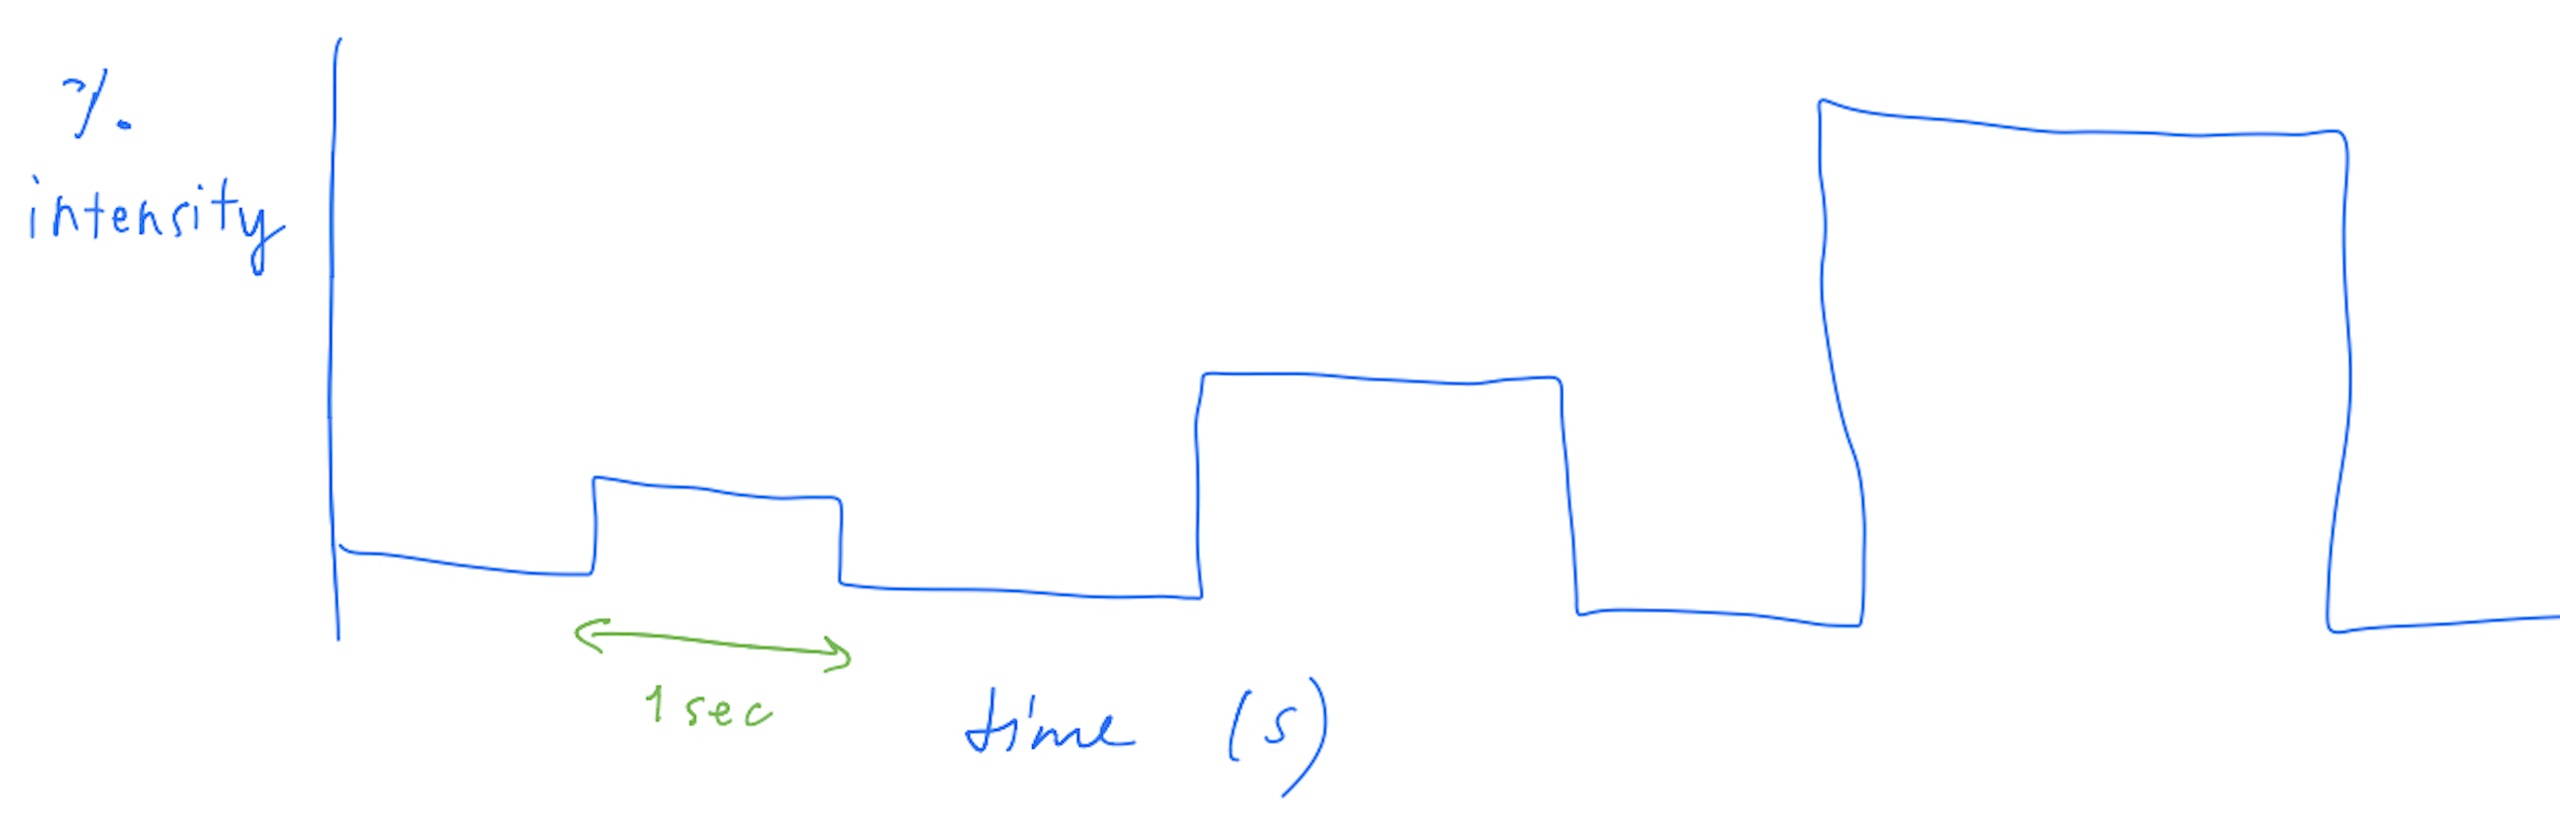

Experiment code to run:

In [ ]:
# Import libraries
import maxlab
import maxlab.system


# EXPERIMENT PARAMETERS ------------------

# Percent inteisity (Max: ~13.8 mW/mm^2)
test_intensities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

hold_time = 100 # MaxWell samples  
time_between_stims = 1000 # MaxWell sampels



#SETUP ----------------------
# Set all 8 GPIO pins to outputs
maxlab.send( maxlab.system.GPIODirection(0b11111111))
maxlab.send( maxlab.system.StatusLED(color=0))



# RUN EXPERIMENT --------------
for intensity in test_intensities: # Sweep intensities
    setArduinoIntensity(intensity)
    maxlab.send( maxlab.system.GPIOOutput(0b01000000)) # On
    maxlab.send( maxlab.system.DelaySamples(hold_time)) # Hold
    maxlab.send( maxlab.system.GPIOOutput(0b00000000)) # Off
    maxlab.send( maxlab.system.DelaySamples(time_between_stims)) # Let cells recover
    

## <font color="LightSeaGreen"> Calibration Experiment 2: Frequency

Fixed intensity, variable frequency

https://www.pnas.org/doi/10.1073/pnas.0700384104

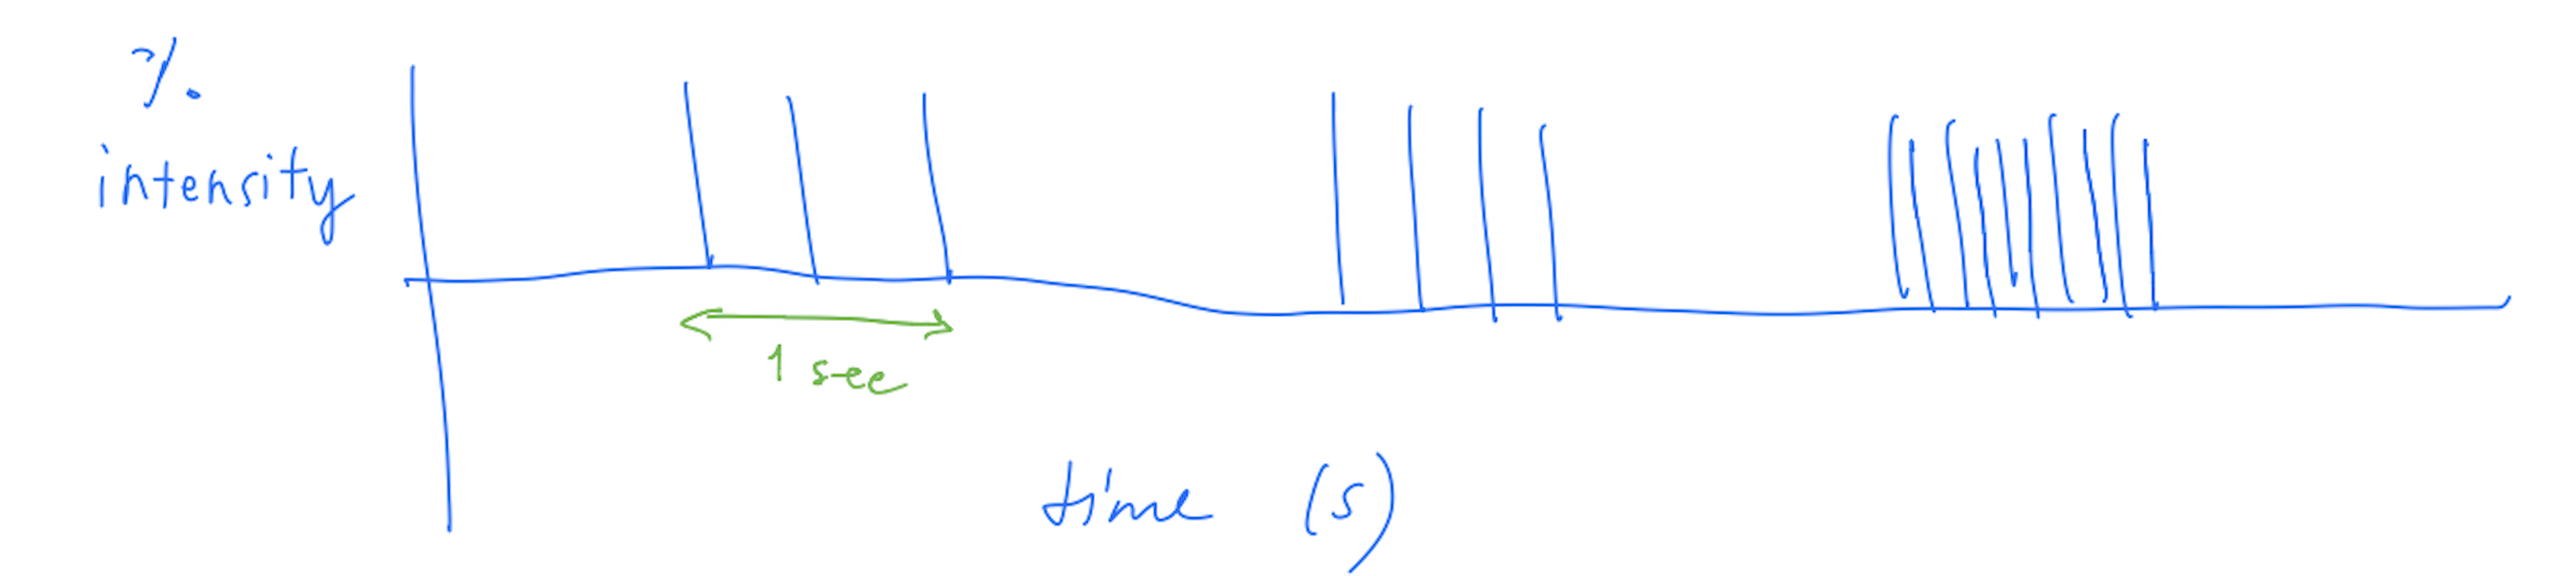

Experiment code to run:

In [ ]:
# Import libraries
import maxlab
import maxlab.system


# EXPERIMENT PARAMETERS ------------------

test_frequencies = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


intensity = 0.3 # Percent inteisity (Max: ~13.1 mW/mm^2) ==> ~3.93mW/mm^2
hold_time = 20000 # MaxWell samples ==> 1 second 
time_between_stims = 20000 * 5 # MaxWell sampels  ==> 5 seconds 


#SETUP ----------------------
# Set all 8 GPIO pins to outputs
maxlab.send( maxlab.system.GPIODirection(0b11111111))
maxlab.send( maxlab.system.StatusLED(color=0))


# RUN EXPERIMENT --------------
for intensity in test_intensities: # Sweep intensities
    setArduinoIntensity(intensity)
    maxlab.send( maxlab.system.GPIOOutput(0b01000000)) # On
    maxlab.send( maxlab.system.DelaySamples(hold_time)) # Hold
    maxlab.send( maxlab.system.GPIOOutput(0b00000000)) # Off
    maxlab.send( maxlab.system.DelaySamples(time_between_stims)) # Let cells recover
    

==>> Try Sinusiodal instead of square -- any change in response

## <font color="LightSeaGreen"> Additional Stim Experiments - Brainstorm

- In lit: second long pulses






Can we change functional connectoins? 
- 30-50 Hz -- > induce LTP?
- Induce LTD at lower frequencies?



# <font color="green">GUI's

Here we build GUI's based off of pieces of the notebook.

**Reference Material**
* [Jupyter Widget list](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html)


## <font color="green"> Power Density GUI

This interface allows users to easily output the power density using the inputs <font color="red">(what are these)</font>. The code comes from thes [power density](http://wetai.gi.ucsc.edu:8004/notebooks/Projects/Optogenetics/ArduinoOptogeneticsWaveform_V4%20(1).ipynb#-Calculate-Power-Density-$\frac{mW}{mm^2}$) section.

### <font color="lime">Widgets

List all the widgets we will use

In [ ]:
ipw_beam_diam_txt = ipw.Label("Beam Diamteter ($\mu$m) ")
ipw_beam_diam = ipw.FloatText( value=200,  layout=ipw.Layout(width="auto",  margin="0 0 10px 0") )
ipw_avg_mw_txt = ipw.Label(" Average Power (mW) ")
ipw_avg_mw =  ipw.FloatText( value=0.4,  layout=ipw.Layout(width="auto"))
ipw_density_btn = ipw.Button(description="Get Density", button_style='Success', layout=ipw.Layout(margin="20px 0 0 50px") )
ipw_density_out = ipw.HTMLMath( f"<p>&nbsp</p>" )

Put them int a box

In [ ]:
Arduino.GUI.power_density = ipw.VBox([ ipw.HBox([ipw_beam_diam_txt, ipw_beam_diam]), ipw.HBox([ipw_avg_mw_txt, ipw_avg_mw]), ipw_density_btn, ipw_density_out])
Arduino.GUI.power_density

### <font color="blue">Function

Function saves the power density to the variable `Arduino.data.power_density`

In [ ]:
def f_power_density(b):
    clear_output()
    display( Arduino.GUI.power_density )  
    Arduino.data.power_density= powerdensity( ipw_avg_mw.value, ipw_beam_diam.value )  # Save density value
    ipw_density_out.value = r"""<p>&nbsp</p><p>The power density is <b>"""+str(round(Arduino.data.power_density,3))+r"""</b> $\frac{mW}{mm^2}$</p>
                                <p>This has been saved to the variable <code>Arduino.data.power_density</code></p>"""
ipw_density_btn.on_click( f_power_density )
Arduino.GUI.f_power_density = f_power_density


## <font color="green"> Waveforme chooser

### Choosing Signal

Create widgets

In [ ]:
ipw_btn_flat_signal = ipw.Button(description="Constant")
ipw_btn_var_signal = ipw.Button(description="Variable")
ipw_txt_choose_signal= ipw.HTML(f"""<h3>Choose the signal type</h3><p><code>Single</code> is a signal whose amplitude does not change over time.
                                    <code>Variable</code> lets you select waveforms that change over time.</p>""")

Create box

In [ ]:
Arduino.GUI.signal = ipw.VBox([ ipw_txt_choose_signal, ipw.HBox([ipw_btn_flat_signal,ipw_btn_var_signal]) ])
Arduino.GUI.signal 

functions:

In [ ]:
def f_flat_display(b):
    clear_output() 
    display(box_flat_signal)

def f_variable_display(b):
    clear_output() 
    display(box_cycle_speed)
    
ipw_btn_flat_signal.on_click( f_flat_display )
ipw_btn_var_signal.on_click(  f_variable_display )

### Refresh Button

This button will allow the use to always get back to the top of the app

In [ ]:
ipw_wave_refresh = ipw.Button(  icon="refresh", button_style="info", layout=ipw.Layout(width='auto'))
ipw_wave_refresh

Code that does refresh

In [ ]:
def refresh_wave(b):
    clear_output()
    display(Arduino.GUI.signal )
ipw_wave_refresh.on_click(refresh_wave)

### Constant Signal 

#### widgets

In [ ]:
ipw_flat_txt  = ipw.HTMLMath(r"<h5>Choose magnitude of the light's intensity on a scale from $0$ to $1$</h5>")
ipw_flat_label= ipw.Label("Intensity Fraction ")
ipw_flat_frac = ipw.BoundedFloatText(value=.5,min=0,max=1.0, step=.001, layout=ipw.Layout(width="100px", margin="0 0 10px 0") )
ipw_flat_btn = ipw.Button(description="Submit")

box_flat_signal = ipw.VBox([ipw_flat_txt, ipw.HBox([ipw_flat_label,ipw_flat_frac ]), ipw.HBox([ipw_flat_btn,ipw_wave_refresh])   ])

In [ ]:
box_flat_signal

#### Function

In [ ]:
def f_flat_submit(b):
    # Set Data
    Arduino.data.constant_signal = True
    Arduino.data.intensity_fraction= ipw_flat_frac.value
    Arduino.data.DAC_intensity_bitvalue = int(round(4096 * Arduino.data.intensity_fraction))
    
    # Set Display
    clear_output() 
    display(ipw.HTML(f"<h3 class='text-success'>Finished</h3><p>The signal has been set to an intensity of <b>{Arduino.data.intensity_fraction:.3f}</b> . This value has been saved to the variable <code>Arduino.data.intensity_fraction</code></p>"))
    display(ipw_wave_refresh)
    #print(DAC_intensity_bitvalue)
    #print("Expected Voltage:", 5*intensity_fraction)
    
ipw_flat_btn.on_click(f_flat_submit) 
    

### Variable Signal

#### Cycles and Speed Display

Create all widgets

In [ ]:
ipw_txt_cycle = ipw.HTML(f"<p class='text-danger'>This section is a work in progress that will likely be changed later. For now it just determiens the number of packets.</p>")
ipw_cycle_txt = ipw.Label("Cycle ?? ")
ipw_cycle = ipw.IntText( value=200,  layout=ipw.Layout(width="auto",  margin="0 0 10px 0") )
ipw_speed_txt = ipw.Label(" Speed ?? ")
ipw_speed =  ipw.IntText( value=7.5,  layout=ipw.Layout(width="auto"))
ipw_cycle_btn = ipw.Button(description="Submit")

Put in a box

In [ ]:
box_cycle_speed = ipw.VBox([ ipw_txt_cycle, ipw.HBox([ipw_cycle_txt, ipw_cycle]), ipw.HBox([ipw_speed_txt, ipw_speed]), ipw_cycle_btn ])
box_cycle_speed

add function to the box

In [ ]:
def f_set_cycle(b):    
    # Set Variables
    Arduino.data.cycles = ipw_cycle.value
    Arduino.data.speed =  ipw_speed.value
    Arduino.data.t = np.linspace(0, Arduino.data.cycles, Arduino.data.speed, endpoint=True)
    
    # Display waveform selection box
    clear_output() 
    display( box_waveform )

ipw_cycle_btn.on_click( f_set_cycle )

#### Select Waveform Display

create all widgets

In [ ]:
ipw_wave_txt   = ipw.HTML(f"""<p>Your number of cycles and speed have been saved to the variables <code>Arduino.data.cycles</code> and <code>Arduino.data.speed</code></p><p>Use the dropdown below to select the type of waveform that you would like to use on the Arduino...</p>""") 
ipw_wave_label = ipw.Label("Select Waveform ")
ipw_wave_dropdown = ipw.Dropdown( options=['random','sine','cosine','sawtooth','ramp','sparse random'],value='random', layout=ipw.Layout(width="auto") )

ipw_wave_sine_txt= ipw.Label("Sine Amplitude")
ipw_wave_sine =  ipw.FloatText(value=1, step=.1 , layout=ipw.Layout(width="50px")  )
ipw_wave_cos_txt= ipw.Label("Cosine Amplitude")
ipw_wave_cos =  ipw.FloatText(value=1, step=.1, layout=ipw.Layout(width="50px"))
ipw_wave_sine_row= ipw.HBox([ipw_wave_sine_txt,ipw_wave_sine,ipw_wave_cos_txt,ipw_wave_cos ] , layout=ipw.Layout(visibility="hidden"))

ipw_wave_submit = ipw.Button(description="Submit")


Put widgets in box

In [ ]:
box_waveform = ipw.VBox([ ipw_wave_txt, ipw.HBox([ipw_wave_label,ipw_wave_dropdown]), ipw_wave_sine_row, ipw_wave_submit])
box_waveform

add functions

In [ ]:
def f_show_sine(b):
    #print("hello")
    if ipw_wave_dropdown.value == "sine" or ipw_wave_dropdown.value=="cosine":
        ipw_wave_sine_row.layout.visibility = "visible"
    else:
        ipw_wave_sine_row.layout.visibility = "hidden"
        
ipw_wave_dropdown.observe( f_show_sine, names="value" )

In [ ]:
def f_set_wave(b):
    # Set wave based on dropdown selection
    if ipw_wave_dropdown.value == "sine":
        f = 1 + np.sin(2 * np.pi * t)
    if ipw_wave_dropdown.value == "cosine":
        f = 1 - np.cos(2 * np.pi * t)
    if ipw_wave_dropdown.value == "sawtooth":
        f = 1 + signal.sawtooth(2 * np.pi * 1 * t, 0.5) #sawtooth/triangle (width = 1 gives right-sided sawtooth, width = 0 gives a left-sided sawtooth, width = 0.5 gives a symmetric triangle.)
    if ipw_wave_dropdown.value == "ramp":
        f = (t*0)+1 
    if ipw_wave_dropdown.value == "random":
        f = np.random.rand(speed,1) 
    if ipw_wave_dropdown.value == "sparse random":
        f = sparse.random(speed, 1, density=0.10).toarray()
    
    # Check waveform is good
    Arduino.data.f = (f*(4096/2)).astype(np.int16)
    assert np.any( Arduino.data.f  > 4096) == False, "Assertion Error: number greater than 4096, will overflow 12-bit DAC"
    
    # Clear output add text
    clear_output() 
    display( ipw.HTML("Here's a graphs of the waveform, some data was saved...") )

    # Display plotted waveform
    plt.plot(t, f)
    plt.rcParams.update({'font.size': 20})
    plt.xlabel("time (ms)") 
    plt.ylabel("Intensity (%)")          
    plt.show()
        
ipw_wave_submit.on_click( f_set_wave)
